# Robustness of Crayfish Nervous System to Environmental pH
## Step 1: Format Data

In [ ]:
import neo, os
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
files = [f for f in os.listdir('raw') if f.endswith('abf')]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for f in files:

    ## Load recordings.
    recordings, = neo.AxonIO(filename='raw/%s' %f).read_block().segments
    signal, = recordings.analogsignals

    ## Concatenate raw recordings.
    data = np.hstack([np.asarray(signal, dtype=np.float64)  * 1e-6]).T

    ## Create info object.
    sfreq = float(signal.sampling_rate)
    ch_names = ['nerve']
    ch_types = 'bio'

    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    ## Create Raw object.
    raw = RawArray(data, info, verbose=False)

    ## Save Raw object.  
    raw.save('raw/%s' %f.replace('.abf','_raw.fif'), overwrite=True, verbose=False)
    
print('Done.')

## Step 2: Preprocess Data

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import datetime
from mne.io import Raw
from pandas import DataFrame
from spike_sorting import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
files = [f for f in os.listdir('raw') if f.endswith('fif')]

## Filter parameters.
l_freq = 300
h_freq = 3000

## Spike sorting parameters.
k = 5
reject = 200 # uV

## Resampling.
rule = '0.5S' # 500 ms

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

for f in files:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load raw.
    raw = Raw('raw/%s' %f, preload=True, verbose=False)

    ## Filter data.
    raw = raw.filter(l_freq, h_freq, picks=[0], method='fir', phase='zero', fir_design='firwin', verbose=False)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Spike sorting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract data.
    data, times = raw.get_data(return_times=True)
    data = data.squeeze() * 1e6
        
    ## Find peaks.
    threshold = find_threshold(data, k)
    peak_loc, peak_mag = peak_finder(data, threshold)
    peak_loc = raw.times[peak_loc]
    
    ## Amplitude rejection.
    peak_loc = peak_loc[peak_mag < reject]
    peak_mag = peak_mag[peak_mag < reject]
    
    ## Determine optimal number of clusters with gap statistic.
    gap = gap_statistic(peak_mag.reshape(-1, 1), n_clusters=3, n_ref=10)
    n_clusters = np.argmax(gap) + 1
    
    ## Spike clustering.
    km = KMeans(n_clusters=n_clusters, random_state=47404)
    fit = km.fit(peak_mag.reshape(-1, 1))
    clusters = fit.predict(peak_mag.reshape(-1, 1))

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Assemble into DataFrame.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize DataFrame.
    df = DataFrame(np.vstack([clusters, peak_loc, peak_mag]).T, columns=('Cluster','Time','Amplitude'))
    df.index = df.Time.apply(seconds_to_timeindex)
    
    ## Re-sort cluster index by mean amplitude in descending order.
    order = np.argsort( df.groupby('Cluster').Amplitude.mean().as_matrix() )
    order = np.max(order) - order
    df.Cluster = order[df.Cluster.astype(int)]

    ## Compute ISI (separated by cluster).
    df['ISI'] = False
    for cluster in df.Cluster.unique():
        df.loc[df.Cluster==cluster,'ISI'] = np.insert( np.diff(df.loc[df.Cluster==cluster, 'Time']), 0, np.nan )
    df['ISI'] = df['ISI'].astype(float)
    
    ## Save data.
    df.to_csv('proc/%s' %f.replace('_raw.fif', '.csv'), index=False)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Quality check plots.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize canvas.
    fig = plt.figure(figsize=(16,16))

    ## Plot timeseries samples.
    gs = gridspec.GridSpec(1, 3)
    gs.update(left=0.075, right=0.70, bottom=0.785,  top=0.98, wspace=0.02)

    xlims = [(0.1,1.1), (times.mean()-0.5, times.mean()+0.5), (times.max()-1, times.max())]
    xlabels = ['First 1s', 'Middle 1s', 'Final 1s']

    for i, xlim, xlabel in zip(range(3),xlims,xlabels):

        ## Initialize axis. Define indices.
        ax = plt.subplot(gs[i])
        ix1 = np.logical_and(times >= xlim[0], times <= xlim[1])
        ix2 = np.logical_and(peak_loc >= xlim[0], peak_loc <= xlim[1])

        ## Plot spikes.
        plot_spikes(times[ix1], data[ix1], df.Time[ix2], clusters=df.Cluster[ix2],
                    threshold=threshold, ax=ax) 

        ## Add info.
        ax.set(xlim=xlim, xticks=[], xlabel=xlabel, ylim=(-50,75), yticks=[])
        if not i: ax.set(yticks=np.arange(-50,80,25), ylabel=r'Amplitude ($\mu V$)')

    ## Plot timeseries of spike counts.
    gs = gridspec.GridSpec(3, 1)
    gs.update(left=0.075, right=0.70, bottom=0.05,  top=0.74, wspace=0, hspace=0.25)

    ax = plt.subplot(gs[0])
    for cluster in df.Cluster.unique():
        resample = df.loc[df.Cluster==cluster,'Amplitude'].resample(rule).count()
        ax.plot(timeindex_to_seconds(resample.index), resample.as_matrix()*2)
    ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)', ylabel=r'Frequency (Hz)')

    ## Plot timeseries of magnitudes.
    ax = plt.subplot(gs[1])
    for cluster in df.Cluster.unique():
        resample = df.loc[df.Cluster==cluster,'Amplitude'].resample(rule).mean()
        ax.plot(timeindex_to_seconds(resample.index), resample.as_matrix())
    ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)', ylabel=r'Amplitude ($\mu V$)')

    ## Plot timeseries of ISI.
    ax = plt.subplot(gs[2])
    for cluster in df.Cluster.unique():
        resample = df.loc[df.Cluster==cluster,'ISI'].resample(rule).mean()
        ax.plot(timeindex_to_seconds(resample.index), resample.as_matrix())
    ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)', ylabel=r'ISI (s)')

    ## Plot gap statistics.
    gs = gridspec.GridSpec(4, 1)
    gs.update(left=0.775, right=0.98, bottom=0.05,  top=0.98, wspace=0, hspace=0.25)

    ax = plt.subplot(gs[0])
    sns.barplot(np.arange(3)+1,gap, palette=sns.cubehelix_palette(n_colors=3), ax=ax)
    ax.set(xticklabels=[r'$K=1$',r'$K=2$',r'$K=3$'], ylabel='Gap Statistic')

    ## Plot spike counts.
    ax = plt.subplot(gs[1])
    sns.countplot(x='Cluster', data=df, ax=ax)
    ax.set(xticklabels=[r'%0.0f $\mu V$' %a for a in df.groupby('Cluster').Amplitude.mean()], ylabel='Frequency')

    ## Plot histogram of spike magnitudes.
    ax = plt.subplot(gs[2])
    for cluster in df.Cluster.unique():
        arr = df.loc[df.Cluster==cluster,'Amplitude']
        sns.distplot(arr, hist=False, kde=True, kde_kws=dict(lw=2.5,alpha=0.7))
    ax.set(xlim=(0,100), xticks=[0,50,100], xlabel=r'Amplitude ($\mu$V)', ylabel='Density')

    ## Plot histogram of spike magnitudes.
    ax = plt.subplot(gs[3])
    for cluster in df.Cluster.unique():
        arr = df.loc[df.Cluster==cluster,'ISI'].dropna().astype(float)
        sns.distplot(arr, hist=False, kde=True, kde_kws=dict(lw=2.5,alpha=0.7))
    ax.set(xlim=(-0.05,1.05), xticks=[0,0.5,1], xlabel=r'ISI (s)', ylabel='Density')

    sns.despine()
    plt.subplots_adjust(left=0.1, right=0.9, wspace=0.2)
    plt.savefig('qc/%s' %f.replace('_raw.fif', '.png'), dpi=150)
    plt.close('all')
    
print('Done.')

# Step 3: Statistical Analysis

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

files = os.listdir('proc')

data = []
for f in files:
    
    ## Parse filename.
    _, pH, recording, epoch = f.replace('.csv','').split('_')
    pH = float(pH.replace('pH','')) / 10
    
    ## Load CSV.
    df = read_csv('proc/%s' %f)
    
    ## Store metadata. Append to list.
    df.insert(0, 'Epoch', epoch)
    df.insert(0, 'Recording', recording)
    df.insert(0, 'pH', pH)
    data.append(df)
    
## Merge DataFrames.
data = concat(data)

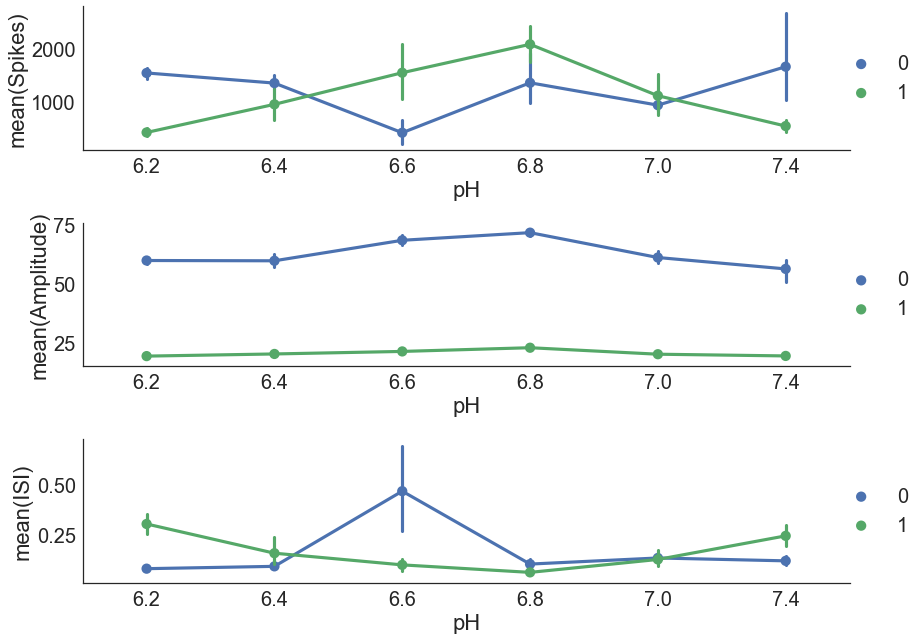

In [34]:
## Testing
test = data[data.pH != 7.2].copy()
test = test[~np.logical_and(test.pH==7.4, test.Recording==1)]

gb = test.groupby(['pH','Epoch','Cluster'])
counts = gb.Amplitude.count().reset_index()
counts.columns = ['pH','Epoch','Cluster','Spikes']
gb = gb.mean().reset_index()
gb = gb.merge(counts, on=['pH','Epoch','Cluster'])

fig, axes = plt.subplots(3,1,figsize=(12,9))
sns.pointplot('pH', 'Spikes', 'Cluster', data=gb, ax=axes[0])
axes[0].legend(loc=7, bbox_to_anchor=(1.1,0.5))
sns.pointplot('pH', 'Amplitude', 'Cluster', data=gb, ax=axes[1])
axes[1].legend(loc=7, bbox_to_anchor=(1.1,0.5))
sns.pointplot('pH', 'ISI', 'Cluster', data=gb, ax=axes[2])
axes[2].legend(loc=7, bbox_to_anchor=(1.1,0.5))

sns.despine()
plt.tight_layout()